In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
df_medcare = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Medical Inflation/medical_care.xlsx', sheet_name='Sheet1')
df_ps = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Medical Inflation/physicians_services.xlsx', sheet_name='Sheet1')
df_hs = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Medical Inflation/hospital_services.xlsx', sheet_name='Sheet1')
df_pd = pd.read_excel('/content/drive/MyDrive/Blackcoffer/Medical Inflation/prescription_drugs.xlsx', sheet_name='Sheet1')

df_md = df_medcare[['Year', 'Annual']]
df_ps = df_ps[['Year', 'Annual']]
df_hs = df_hs[['Year', 'Annual']]
df_pd = df_pd[['Year', 'Annual']]

df_md.dropna(inplace=True)
df_ps.dropna(inplace=True)
df_hs.dropna(inplace=True)
df_pd.dropna(inplace=True)

df_md.drop([0, 1, 2, 3, 4, 5], inplace=True)
df_ps.drop([0, 1, 2, 3, 4, 5], inplace=True)
df_pd.drop([0, 1, 2, 3, 4, 5], inplace=True)
df_hs.drop([1, 2, 3, 4], inplace=True)

df_md.reset_index(drop=True, inplace=True)
df_ps.reset_index(drop=True, inplace=True)
df_hs.reset_index(drop=True, inplace=True)
df_pd.reset_index(drop=True, inplace=True)

## Medical Care Data analysis

In [ ]:
df_med = pd.DataFrame({
    'year': ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
    '1941-1950': df_md['Annual'].values[0:10],
    '1951-1960': df_md['Annual'].values[10:20],
    '1961-1970': df_md['Annual'].values[20:30],
    '1971-1980': df_md['Annual'].values[30:40],
    '1981-1990': df_md['Annual'].values[40:50],
    '1991-2000': df_md['Annual'].values[50:60],
    '2001-2010': df_md['Annual'].values[60:70],
    '2011-2020': df_md['Annual'].values[70:80],
})
df_med.head()

,year,1941-1950,1951-1960,1961-1970,1971-1980,1981-1990,1991-2000,2001-2010,2011-2020
0,1st,10.4,15.9,22.9,36.1,82.9,177.0,272.8,400.258
1,2nd,10.7,16.7,23.5,37.3,92.5,190.1,285.6,414.924
2,3rd,11.2,17.3,24.1,38.8,100.6,201.4,297.1,425.134
3,4th,11.6,17.8,24.6,42.4,106.8,211.0,310.1,435.292
4,5th,11.9,18.2,25.2,47.5,113.5,220.5,323.2,446.752


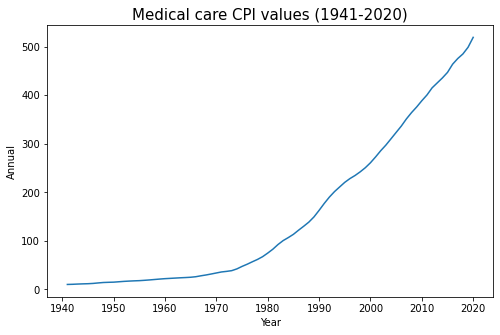

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Year', y='Annual', data=df_md)
plt.title('Medical care CPI values (1941-2020)', size=15)
plt.show()

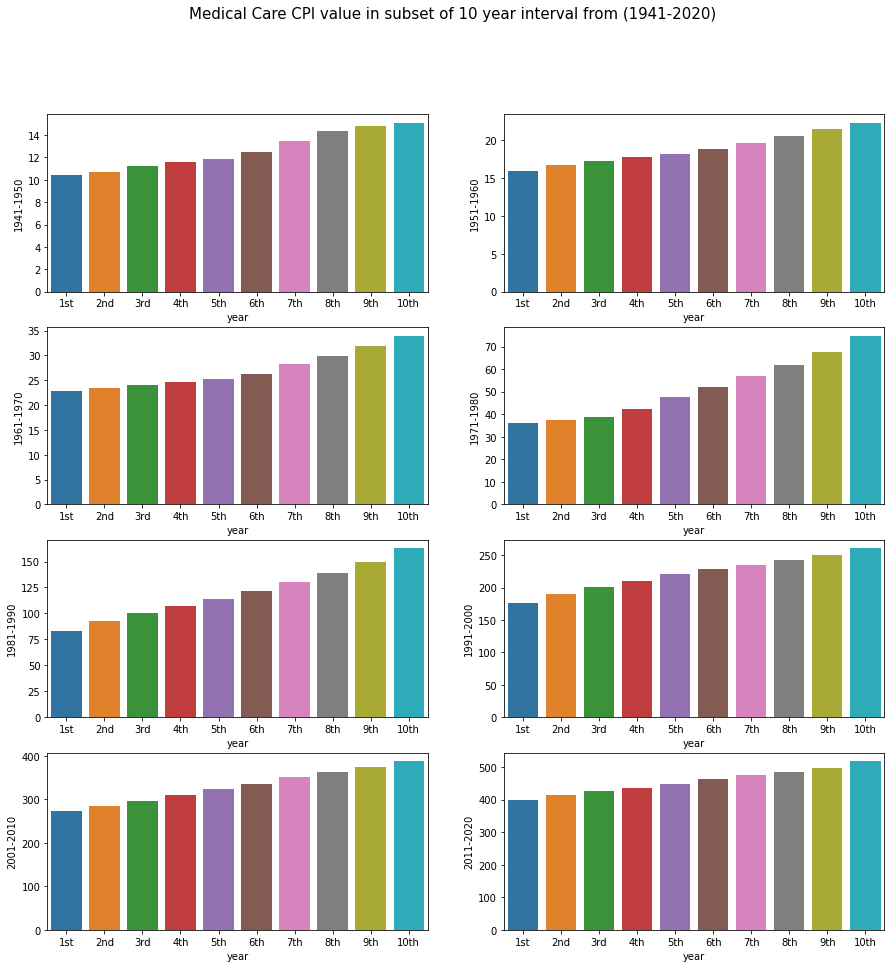

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

plt.suptitle('Medical Care CPI value in subset of 10 year interval from (1941-2020)',  size=15)
sns.barplot(x = 'year', y = '1941-1950', data=df_med, ax=axes[0, 0])
sns.barplot(x = 'year', y = '1951-1960', data=df_med, ax=axes[0, 1])
sns.barplot(x = 'year', y = '1961-1970', data=df_med, ax=axes[1, 0])
sns.barplot(x = 'year', y = '1971-1980', data=df_med, ax=axes[1, 1])
sns.barplot(x = 'year', y = '1981-1990', data=df_med, ax=axes[2, 0])
sns.barplot(x = 'year', y = '1991-2000', data=df_med, ax=axes[2, 1])
sns.barplot(x = 'year', y = '2001-2010', data=df_med, ax=axes[3, 0])
sns.barplot(x = 'year', y = '2011-2020', data=df_med, ax=axes[3, 1])

plt.show()

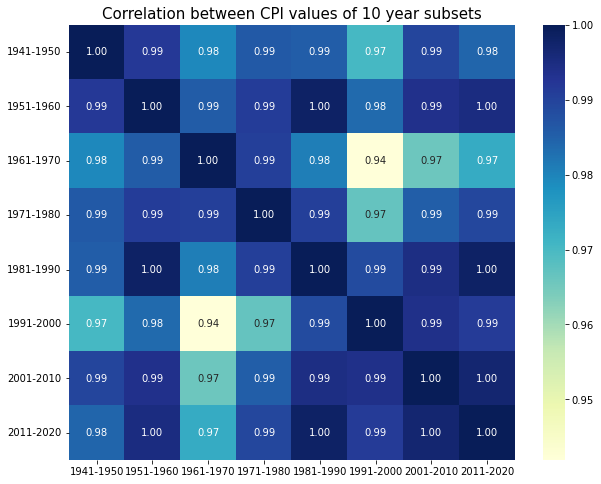

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_med.corr(), annot=True, fmt='.2f',  cmap="YlGnBu")
plt.title('Correlation between CPI values of 10 year subsets', size=15)
plt.show()

## Key points:
  1. As we can see from the bar chart visuals every year CPI values are gradually increasing in each 10 years interval.
  2. Because of increment in CPI values every year, these subsets are highly correlated to each other. (we can see in above heatmap)

### Let's try to predict next 10 year's result.

#### Note -> Here I am using CPI values from (1941 - 2010) as a training data and I will predict the result for (2011-2020) so we can compare actual values and predicted values by model.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_md[['Annual']])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
train, test = df_scaled[:-11, :], df_scaled[-11:, :]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.29 RMSE
Test Score: 16.36 RMSE


In [ ]:
df_result = pd.DataFrame({
    'Year': ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    'Actual CPI': testY[0],
    'Predicted CPI': testPredict[:, 0]
})
df_result

,Year,Actual CPI,Predicted CPI
0,2011,400.258,395.963135
1,2012,414.924,406.330170
2,2013,425.134,418.984833
3,2014,435.292,427.658875
4,2015,446.752,436.177887
5,2016,463.675,445.655640
6,2017,475.322,459.393555
7,2018,484.707,468.669922
8,2019,498.413,476.039154
9,2020,518.876,486.632782


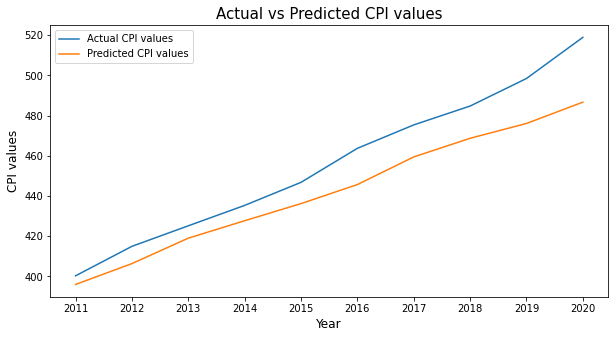

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_result['Year'], df_result['Actual CPI'], label='Actual CPI values')
plt.plot(df_result['Year'], df_result['Predicted CPI'], label='Predicted CPI values')
plt.title('Actual vs Predicted CPI values', size=15)
plt.xlabel('Year', size=12)
plt.ylabel('CPI values', size=12)
plt.legend()
plt.show()

## Key Points: 
1. From the above graph we can see in the starting (2011),  predicted CPI values are close to actual values and when the year increases the difference between actual values and predicted values increases. 

2. I think next 10 years prediction of CPI values are very tough to predict because increment in next 10 years CPI values are much more higher than the past 10 year.

3. But if we want to predict next 3 to 4 year values we can easily predict we can see from the above graph the predicted values are close to actual values.


### I performed same analysis on subcategories Let's see some interesting results 

# Physician Services Data Analysis (Subcategory)

In [ ]:
df_phy = pd.DataFrame({
    'year': ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
    '1941-1950': df_ps['Annual'].values[0:10],
    '1951-1960': df_ps['Annual'].values[10:20],
    '1961-1970': df_ps['Annual'].values[20:30],
    '1971-1980': df_ps['Annual'].values[30:40],
    '1981-1990': df_ps['Annual'].values[40:50],
    '1991-2000': df_ps['Annual'].values[50:60],
    '2001-2010': df_ps['Annual'].values[60:70],
    '2011-2020': df_ps['Annual'].values[70:80],
})
df_phy.head()

,year,1941-1950,1951-1960,1961-1970,1971-1980,1981-1990,1991-2000,2001-2010,2011-2020
0,1st,11.3,16.3,22.4,36.9,84.9,170.5,253.6,340.301
1,2nd,11.5,17.0,23.1,38.0,92.9,181.2,260.6,347.306
2,3rd,12.3,17.4,23.6,39.3,100.1,191.3,267.7,354.161
3,4th,12.8,18.0,24.2,42.9,107.0,199.8,278.3,359.097
4,5th,13.1,18.6,25.1,48.1,113.3,208.8,287.5,366.082


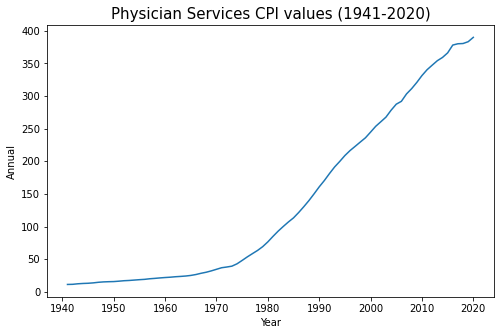

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Year', y='Annual', data=df_ps)
plt.title('Physician Services CPI values (1941-2020)', size=15)
plt.show()

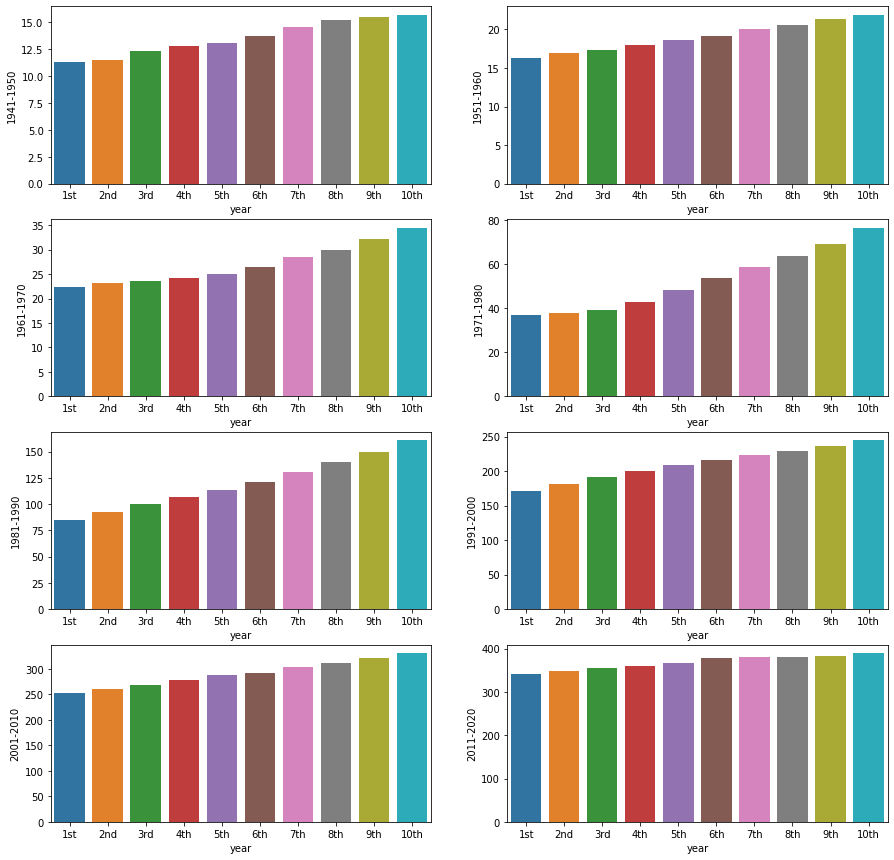

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

sns.barplot(x = 'year', y = '1941-1950', data=df_phy, ax=axes[0, 0])
sns.barplot(x = 'year', y = '1951-1960', data=df_phy, ax=axes[0, 1])
sns.barplot(x = 'year', y = '1961-1970', data=df_phy, ax=axes[1, 0])
sns.barplot(x = 'year', y = '1971-1980', data=df_phy, ax=axes[1, 1])
sns.barplot(x = 'year', y = '1981-1990', data=df_phy, ax=axes[2, 0])
sns.barplot(x = 'year', y = '1991-2000', data=df_phy, ax=axes[2, 1])
sns.barplot(x = 'year', y = '2001-2010', data=df_phy, ax=axes[3, 0])
sns.barplot(x = 'year', y = '2011-2020', data=df_phy, ax=axes[3, 1])

plt.show()

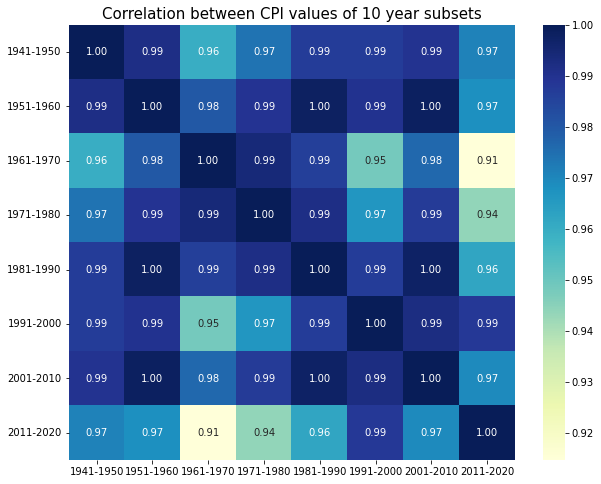

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_phy.corr(), annot=True, fmt='.2f',  cmap="YlGnBu")
plt.title('Correlation between CPI values of 10 year subsets', size=15)
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_ps[['Annual']])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
train, test = df_scaled[:-11, :], df_scaled[-11:, :]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.28 RMSE
Test Score: 9.99 RMSE


In [ ]:
df_result = pd.DataFrame({
    'Year': ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    'Actual CPI': testY[0],
    'Predicted CPI': testPredict[:, 0]
})
df_result

,Year,Actual CPI,Predicted CPI
0,2011,340.301,333.876434
1,2012,347.306,341.281616
2,2013,354.161,346.978119
3,2014,359.097,352.479919
4,2015,366.082,356.396851
5,2016,378.082,361.876160
6,2017,380.086,371.115601
7,2018,380.451,372.637177
8,2019,383.228,372.913696
9,2020,389.900,375.010681


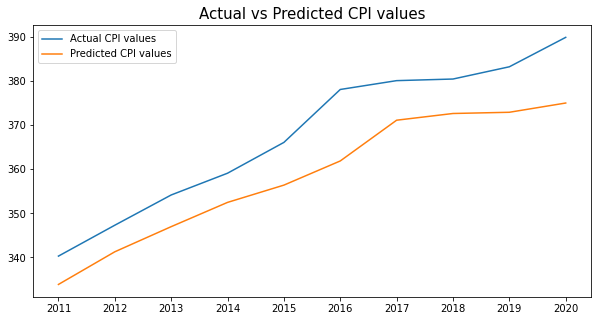

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_result['Year'], df_result['Actual CPI'], label='Actual CPI values')
plt.plot(df_result['Year'], df_result['Predicted CPI'], label='Predicted CPI values')
plt.title('Actual vs Predicted CPI values', size=15)
plt.legend( )
plt.show()

## Key points:
1. From the above graph we can see, the model is following same pattern as it understood by previous year values.

2. Performing same as the previous medical care category, in the starting predicted values are closer to the actual values and then the difference between actual and predicted values are increasing.

# Prescription Drugs Data Analysis (Subcategory)




In [ ]:
df_prd = pd.DataFrame({
    'year': ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
    '1941-1950': df_pd['Annual'].values[0:10],
    '1951-1960': df_pd['Annual'].values[10:20],
    '1961-1970': df_pd['Annual'].values[20:30],
    '1971-1980': df_pd['Annual'].values[30:40],
    '1981-1990': df_pd['Annual'].values[40:50],
    '1991-2000': df_pd['Annual'].values[50:60],
    '2001-2010': df_pd['Annual'].values[60:70],
    '2011-2020': df_pd['Annual'].values[70:80],
})
df_prd.head()

,year,1941-1950,1951-1960,1961-1970,1971-1980,1981-1990,1991-2000,2001-2010,2011-2020
0,1st,31.4,45.5,52.2,47.4,80.8,199.7,300.9,424.981
1,2nd,32.2,46.0,50.1,47.2,90.2,214.7,316.5,440.149
2,3rd,32.5,46.0,48.9,47.1,100.1,223.0,326.3,442.580
3,4th,33.1,46.9,48.3,48.2,109.7,230.6,337.1,458.343
4,5th,33.5,47.6,47.8,51.2,120.1,235.0,349.0,479.315


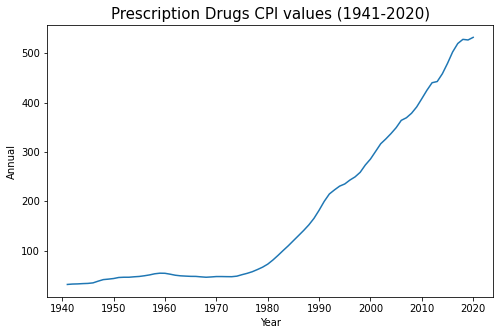

In [ ]:
plt.figure(figsize=(8, 5))
sns.lineplot(x='Year', y='Annual', data=df_pd)
plt.title('Prescription Drugs CPI values (1941-2020)', size=15)
plt.show()

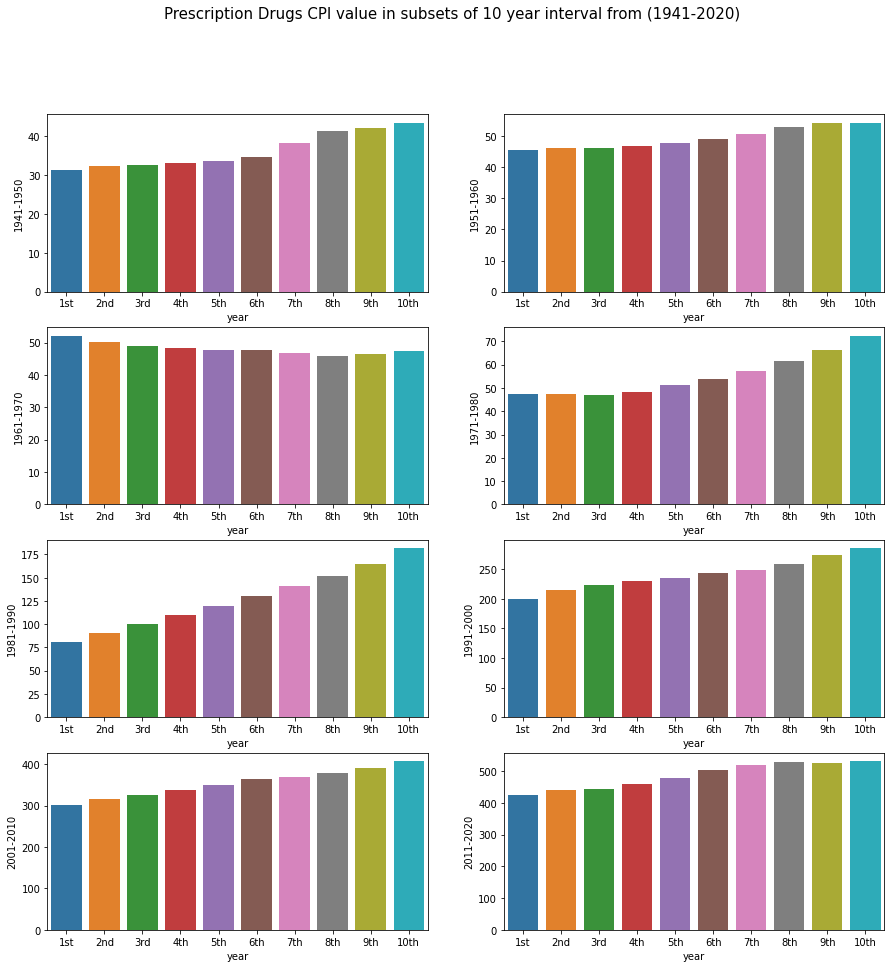

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))

plt.suptitle('Prescription Drugs CPI value in subsets of 10 year interval from (1941-2020)',  size=15)
sns.barplot(x = 'year', y = '1941-1950', data=df_prd, ax=axes[0, 0])
sns.barplot(x = 'year', y = '1951-1960', data=df_prd, ax=axes[0, 1])
sns.barplot(x = 'year', y = '1961-1970', data=df_prd, ax=axes[1, 0])
sns.barplot(x = 'year', y = '1971-1980', data=df_prd, ax=axes[1, 1])
sns.barplot(x = 'year', y = '1981-1990', data=df_prd, ax=axes[2, 0])
sns.barplot(x = 'year', y = '1991-2000', data=df_prd, ax=axes[2, 1])
sns.barplot(x = 'year', y = '2001-2010', data=df_prd, ax=axes[3, 0])
sns.barplot(x = 'year', y = '2011-2020', data=df_prd, ax=axes[3, 1])

plt.show()

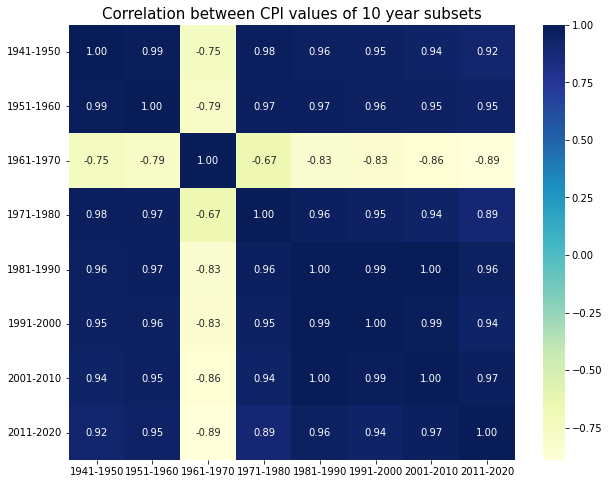

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_prd.corr(), annot=True, fmt='.2f',  cmap="YlGnBu")
plt.title('Correlation between CPI values of 10 year subsets', size=15)
plt.show()

## Key Points: 
* As we can see, 1961-1970 values are negatively correlated to other subsets. Because in that time period the CPI values are decresing.

Let's see it's affect on the prediction result.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_pd[['Annual']])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
train, test = df_scaled[:-11, :], df_scaled[-11:, :]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.22 RMSE
Test Score: 24.08 RMSE


In [ ]:
df_result = pd.DataFrame({
    'Year': ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    'Actual CPI': testY[0],
    'Predicted CPI': testPredict[:, 0]
})
df_result

,Year,Actual CPI,Predicted CPI
0,2011,424.981,411.381409
1,2012,440.149,425.715546
2,2013,442.580,438.112610
3,2014,458.343,440.075531
4,2015,479.315,452.643616
5,2016,502.510,468.937469
6,2017,519.618,486.396851
7,2018,528.008,498.901703
8,2019,526.785,504.920135
9,2020,532.081,504.047516


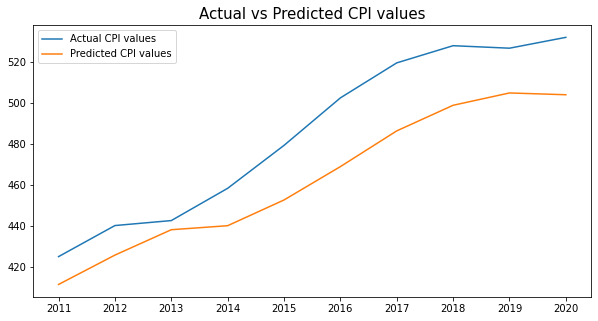

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_result['Year'], df_result['Actual CPI'], label='Actual CPI values')
plt.plot(df_result['Year'], df_result['Predicted CPI'], label='Predicted CPI values')
plt.title('Actual vs Predicted CPI values', size=15)
plt.legend( )
plt.show()

## Key Points:
1. So I think, 1961-1970 CPI values are not affecting much to the results Because above two categories are giving same results but gap between actual values and predicted values are higher from the above two categories.

# Hospital Services Data Analysis (Subcategory)

In this subcategory only 2001 to 2020 values are present on the website. So it is very less data to predict next 10 year results still I tried let's check results. 

In [ ]:
df_hos = pd.DataFrame({
    'year': ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'],
    '2001-2010': df_hs['Annual'].values[0:10],
    '2011-2020': df_hs['Annual'].values[10:20],
})
df_hos.head()

,year,2001-2010,2011-2020
0,1st,123.6,241.213
1,2nd,134.7,253.563
2,3rd,144.7,265.448
3,4th,153.4,278.754
4,5th,161.6,290.132


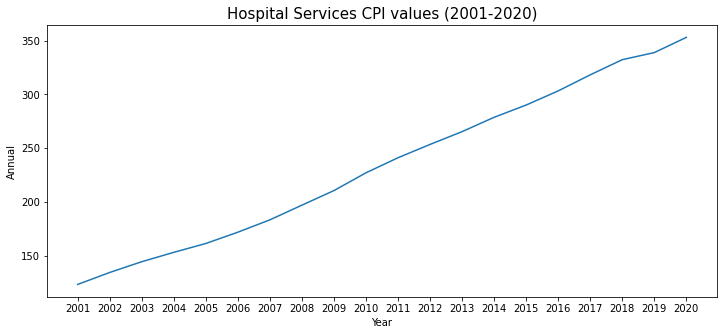

In [ ]:
plt.figure(figsize=(12, 5))
df_hs['Year'] = df_hs['Year'].astype(str)
sns.lineplot(x='Year', y='Annual', data=df_hs)
plt.title('Hospital Services CPI values (2001-2020)', size=15)
plt.show()

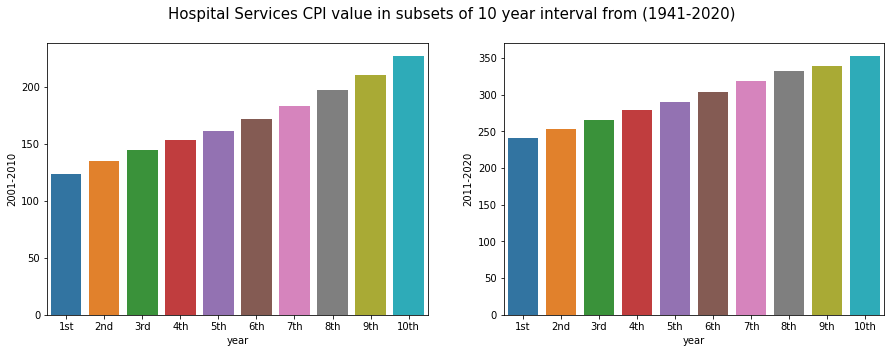

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

plt.suptitle('Hospital Services CPI value in subsets of 10 year interval from (1941-2020)',  size=15)
sns.barplot(x = 'year', y = '2001-2010', data=df_hos, ax=axes[0])
sns.barplot(x = 'year', y = '2011-2020', data=df_hos, ax=axes[1])

plt.show()

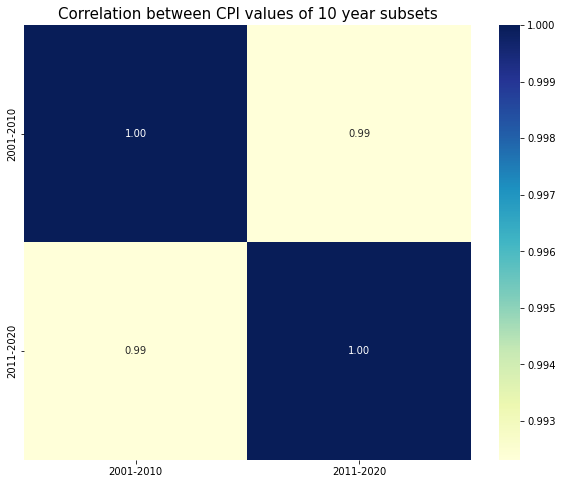

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_hos.corr(), annot=True, fmt='.2f',  cmap="YlGnBu")
plt.title('Correlation between CPI values of 10 year subsets', size=15)
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_hs[['Annual']])

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)
 
train, test = df_scaled[:-11, :], df_scaled[-11:, :]

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=1, verbose=2)

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 11.95 RMSE
Test Score: 51.02 RMSE


In [ ]:
df_result = pd.DataFrame({
    'Year': ['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'],
    'Actual CPI': testY[0],
    'Predicted CPI': testPredict[:, 0]
})
df_result

,Year,Actual CPI,Predicted CPI
0,2011,241.213,211.361115
1,2012,253.563,220.237823
2,2013,265.448,228.145523
3,2014,278.754,235.786270
4,2015,290.132,244.343124
5,2016,303.260,251.636734
6,2017,318.170,259.997620
7,2018,332.237,269.388458
8,2019,338.814,278.114929
9,2020,352.952,282.142792


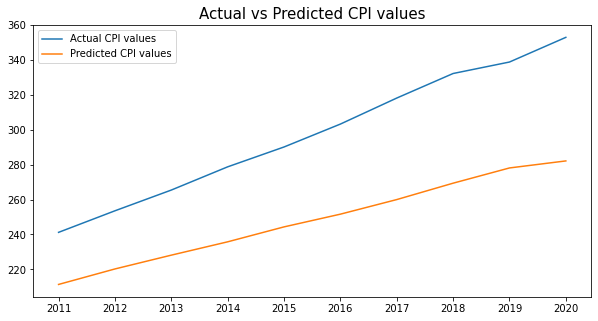

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_result['Year'], df_result['Actual CPI'], label='Actual CPI values')
plt.plot(df_result['Year'], df_result['Predicted CPI'], label='Predicted CPI values')
plt.title('Actual vs Predicted CPI values', size=15)
plt.legend( )
plt.show()

## Key points: 
* As I said in the starting, There is very less data present of this category, so the results are not good, If we have more data we will get very good results.